In [54]:
#Hier wird der Datensatz eingelesen und die Anzahl der Einträge pro Turbine ausgegeben.
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import os
os.environ["SCIPY_ARRAY_API"] = "1"
dataset = pd.read_csv("windmill_data.csv")
dataset["turbine_id"].value_counts()


turbine_id
T004    2139
T007    2135
T020    2135
T023    2133
T013    2132
T021    2131
T019    2129
T015    2129
T012    2128
T001    2127
T009    2127
T005    2125
T016    2123
T008    2122
T006    2121
T010    2120
T018    2119
T017    2119
T003    2117
T022    2117
T025    2116
T011    2115
T002    2114
T014    2113
T024    2107
Name: count, dtype: int64

In [55]:
# Hier werden die Lerndaten vorbereitet.
# Timestamp wird entfernt, da dieser für die Klassifikation nicht relevant ist und das resultat verfälschen könnte.
# Als Dependente Variable wird failure_risk_30d verwendet, da diese angibt, ob ein Fehler in den nächsten 30 Tagen zu erwarten ist.
X = dataset.copy()
X.drop("timestamp", axis=1, inplace=True)

y = X.pop("failure_risk_30d")

In [56]:
# Hier werden alle kategorischen Spalten in numerische Werte umgewandelt, um sie für die Modelle nutzbar zu machen.
from sklearn.preprocessing import LabelEncoder
le_turbine_id = LabelEncoder()
X["turbine_id"] = le_turbine_id.fit_transform(X["turbine_id"])
le_maintenance_team = LabelEncoder()
X["maintenance_team"] = le_maintenance_team.fit_transform(X["maintenance_team"])
le_turbine_type = LabelEncoder()
X["turbine_type"] = le_turbine_type.fit_transform(X["turbine_type"])
le_wind_direction = LabelEncoder()
X["wind_direction"] = le_wind_direction.fit_transform(X["wind_direction"])
X

,turbine_id,turbine_type,maintenance_team,wind_speed_ms,wind_direction,power_output_kw,vibration_mm_s,temperature_c,hydraulic_pressure_bar,days_since_maintenance
0,0,3,1,11.45,5,1562.2,0.750,58.0,182.3,106
1,0,3,1,15.11,7,1800.0,0.774,63.4,173.9,106
2,0,3,1,14.30,6,1800.0,0.885,66.8,186.1,106
3,0,3,1,15.55,7,1800.0,0.005,61.0,182.4,106
4,0,3,1,10.88,7,1340.6,1.248,63.1,180.2,106
...,...,...,...,...,...,...,...,...,...,...
53088,24,3,2,17.23,1,1800.0,1.704,78.7,189.9,51
53089,24,3,2,14.67,6,1800.0,2.244,87.3,176.2,51
53090,24,3,2,10.86,6,1334.5,1.507,79.9,165.9,51
53091,24,3,2,13.09,3,1800.0,1.185,67.2,181.3,51


In [57]:
# impute

# Der Imputer wird verwendet, um fehlende Werte in den Daten zu behandeln.
# Sie werden mit dem Durchschnitt der jeweiligen Spalte ersetzt.
# Um sicherzustellen, dass der Imputer nur auf numerische Spalten angewendet wird, werden nicht-numerische Spalten ausgeschlossen.
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")

X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [58]:
# Es wurde festgestellt, dass die 0 Klasse viel öfter vorkommt als die 1 Klasse.
# Damit die 0 nicht das Bild dominiert, wird ein Undersampling durchgeführt.
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=1491)
X, y = rus.fit_resample(X, y)

In [59]:
# Ein Test Train Split wird durchgeführt, um die Daten in Trainings- und Testdaten aufzuteilen.
# Mit stratefy wird sichergestellt, dass die Verteilung der Klassen im Trainings- und Testset gleich bleibt.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [60]:
# Der hier verwendete Algorithmus ist Random Forest, ein Ensemble-Lernverfahren, das mehrere Entscheidungsbäume kombiniert, um die Genauigkeit und Robustheit der Vorhersagen zu verbessern.
# Nachteil an diesem ist , dass er schwer zu interpretieren ist, da er aus vielen Bäumen besteht und die Entscheidungsfindung nicht so transparent ist wie bei einem einzelnen Entscheidungsbaum.

from sklearn.ensemble import RandomForestClassifier


# Train a RandomForestClassifier with fixed random_state
model = RandomForestClassifier(random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Print classification report
report = classification_report(y_test, y_pred, target_names=["No Failure", "Failure"])
print(report)
print(f"Random Forest accuracy: {accuracy}")

              precision    recall  f1-score   support

  No Failure       1.00      0.95      0.98       104
     Failure       0.95      1.00      0.98       104

    accuracy                           0.98       208
   macro avg       0.98      0.98      0.98       208
weighted avg       0.98      0.98      0.98       208

Random Forest accuracy: 0.9759615384615384


In [61]:
# Python
from sklearn.tree import export_graphviz
import graphviz

# Extrahiere einen Baum aus dem Random Forest
tree = model.estimators_[0]

# Exportiere den Baum in das DOT-Format
dot_data = export_graphviz(
    tree,
    out_file=None,
    feature_names=X.columns,
    class_names=["No Failure", "Failure"],
    filled=True,
    rounded=True,
    special_characters=True
)

# Visualisiere den Baum mit graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Speichert die Visualisierung als Datei
graph.view()  # Öffnet die Visualisierung

'decision_tree.pdf'

                  Feature  Importance
0              turbine_id    0.410149
9  days_since_maintenance    0.154201
1            turbine_type    0.131350
7           temperature_c    0.073765
2        maintenance_team    0.063611
5         power_output_kw    0.048649
3           wind_speed_ms    0.041023
6          vibration_mm_s    0.040199
8  hydraulic_pressure_bar    0.027628
4          wind_direction    0.009425


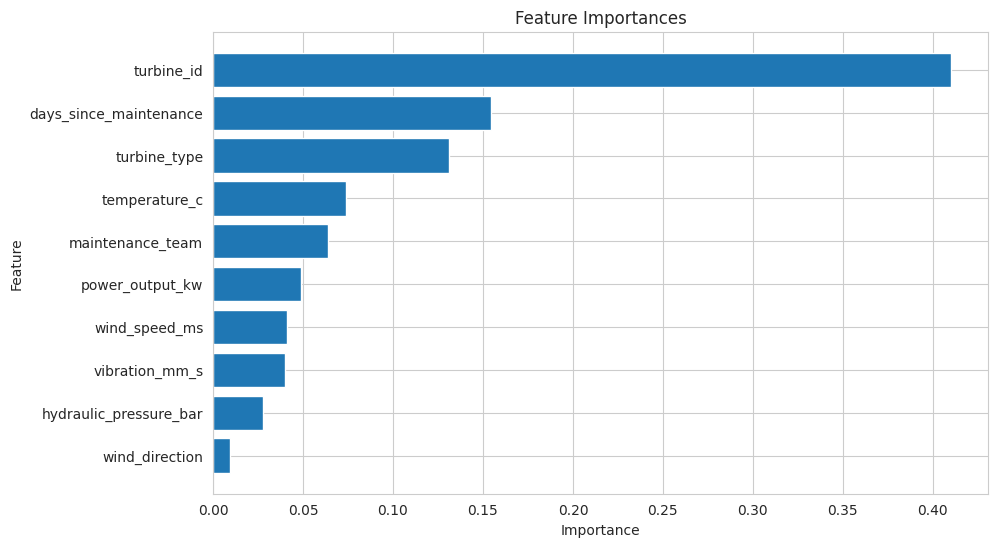

In [62]:
# Python
import pandas as pd
import matplotlib.pyplot as plt

def feature_importances(model_i, X):
    # Feature Importances abrufen
    importances = model_i.feature_importances_

    # In einen DataFrame umwandeln für bessere Übersicht
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Ausgabe der Feature Importances
    print(feature_importances)

    # Optional: Visualisierung der Feature Importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['Feature'], feature_importances['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()  # Wichtigste Features oben anzeigen
    plt.show()

feature_importances(model, X)

In [63]:
# Der Decision Tree Classifier wird hier verwendet, um die Klassifikation durchzuführen.
# Dieser ist einfach zu interpretieren und zu visualisieren, was ihn zu einem guten Ausgangspunkt für die Analyse macht.
# Jedoch neigt dieser zu Überanpassung (Overfitting), insbesondere bei komplexen Datensätzen.
# Schaut man sich den Tree an stellt man fest, dass er sehr tief ist und viele Knoten hat.
# Eventuell könnte eine Überanpassung (Overfitting) vorliegen, da der Baum sehr tief ist und viele Knoten hat.
from sklearn.tree import DecisionTreeClassifier
# Initialize and train the Decision Tree model
model_dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")
model_dt.fit(X_train, y_train)

# Predict on the test set
y_pred = model_dt.predict(X_test)

# Evaluate the model
accuracy = classification_report(y_test, y_pred)
print(f"Model accuracy: {accuracy}")

Model accuracy:               precision    recall  f1-score   support

           0       0.95      0.97      0.96       104
           1       0.97      0.95      0.96       104

    accuracy                           0.96       208
   macro avg       0.96      0.96      0.96       208
weighted avg       0.96      0.96      0.96       208



                  Feature  Importance
0              turbine_id    0.439749
1            turbine_type    0.222339
9  days_since_maintenance    0.190092
2        maintenance_team    0.037422
7           temperature_c    0.036707
6          vibration_mm_s    0.028578
5         power_output_kw    0.022992
3           wind_speed_ms    0.016156
8  hydraulic_pressure_bar    0.005965
4          wind_direction    0.000000


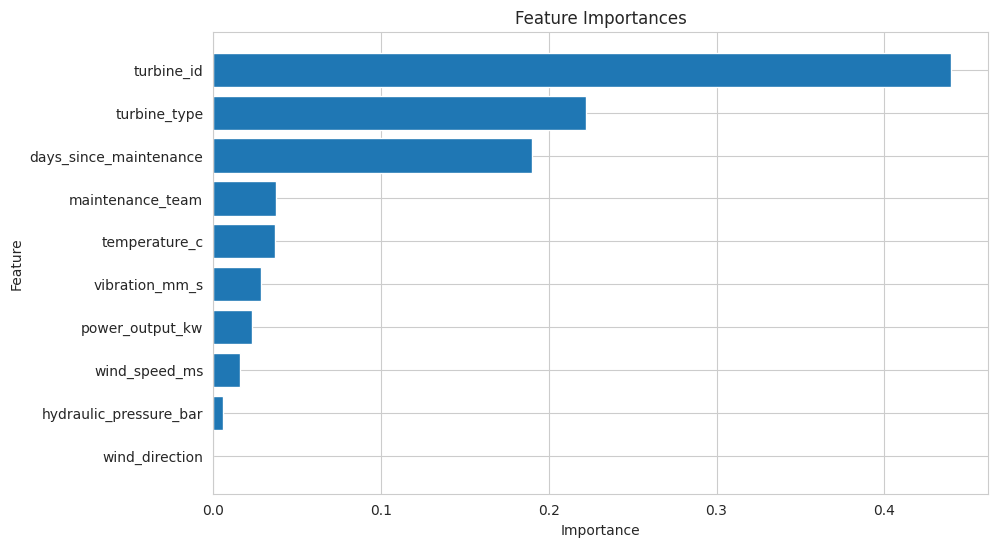

In [64]:
feature_importances(model_dt, X)

In [65]:
# Hier wird KNN verwendet, um die Klassifikation durchzuführen. Diese hat den Vorteil einfach und schnell zu sein.
# Der Nachteil an KNN ist , dass es bei großen Datensätzen ineffizient wird, da es für jede Vorhersage alle Trainingsdaten durchsuchen muss.
from sklearn.neighbors import KNeighborsClassifier
# Initialize and train the KNN model
X.dropna()
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust `n_neighbors` as needed
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = classification_report(y_test, y_pred)
print(f"Model accuracy: {accuracy}")

Model accuracy:               precision    recall  f1-score   support

           0       0.74      0.49      0.59       104
           1       0.62      0.83      0.71       104

    accuracy                           0.66       208
   macro avg       0.68      0.66      0.65       208
weighted avg       0.68      0.66      0.65       208



In [66]:
# Logistische Regression wird hier verwendet um die Klassifikation durchzuführen.
# Vorteile der logistischen Regression sind ihre Einfachheit, Interpretierbarkeit und Effizienz bei der Verarbeitung großer Datensätze.
# Der Nachteil ist, dass sie nur lineare Beziehungen zwischen den Eingangsmerkmalen und der Zielvariable modellieren kann.
from sklearn.linear_model import LogisticRegression
# Initialisiere und trainiere das Modell
log_reg = LogisticRegression(random_state=42, class_weight="balanced")
log_reg.fit(X_train, y_train)

# Vorhersage auf dem Testset
y_pred = log_reg.predict(X_test)

# Modellbewertung
accuracy = classification_report(y_test, y_pred)
print(f"Model accuracy: {accuracy}")

Model accuracy:               precision    recall  f1-score   support

           0       0.77      0.69      0.73       104
           1       0.72      0.80      0.76       104

    accuracy                           0.75       208
   macro avg       0.75      0.75      0.74       208
weighted avg       0.75      0.75      0.74       208



/home/maylis/Dokumente/machine-learning/.venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
# Hier wird ein Esemble-Modell verwendet, um die Vorhersagegenauigkeit zu verbessern soll
# Die Vorsteile von GradientBoosting liegen in seiner Fähigkeit, komplexe Muster zu lernen und dabei die Fehler der vorherigen Modelle zu korrigieren.
from sklearn.ensemble import GradientBoostingClassifier
# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
gb_y_pred = gb_model.predict(X_test)
gb_accuracy = classification_report(y_test, gb_y_pred)
print(f"Gradient Boosting Accuracy: {gb_accuracy}")

Gradient Boosting Accuracy:               precision    recall  f1-score   support

           0       1.00      0.96      0.98       104
           1       0.96      1.00      0.98       104

    accuracy                           0.98       208
   macro avg       0.98      0.98      0.98       208
weighted avg       0.98      0.98      0.98       208



In [68]:
# AdaBoost Classifier wird hier verwendet, um zu schauen, wie gut es mit den Daten funktioniert.
# Die Vorteile von AdaBoost liegen in seiner Fähigkeit, schwache Klassifikatoren zu starken zu kombinieren und dabei die Fehler der vorherigen Modelle zu korrigieren.
from sklearn.ensemble import AdaBoostClassifier
# Initialize and train the AdaBoost model
ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(X_train, y_train)

# Predict on the test set
ada_y_pred = ada_model.predict(X_test)

# Evaluate the model
ada_accuracy = classification_report(y_test, ada_y_pred)

In [69]:
# Hier wird eine Tabelle erstellt, die die Ergebnisse der Klassifikationsmodelle zusammenfasst.
# Dafür wird ein cross eval mit StratifiedKFold verwendet, um die Modelle zu bewerten.
# Die ergebnisse nach jedem Training werden in einer Liste gespeichert und anschließend in ein DataFrame umgewandelt.
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Modelle definieren
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
        "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=100, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
}

# Stratified K-Fold definieren
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tabelle initialisieren
results = []

# Alle Modelle durchlaufen
for name, model in models.items():
    y_pred = cross_val_predict(model, X, y, cv=skf)

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)

    results.append({
        "Modell": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
    })

# In DataFrame umwandeln
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("classification_report.csv", index=False)


/home/maylis/Dokumente/machine-learning/.venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maylis/Dokumente/machine-learning/.venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https

                Modell  Accuracy  Precision    Recall  F1-Score
0        Random Forest  0.972115   0.953789  0.992308  0.972667
1  Logistic Regression  0.732692   0.710069  0.786538  0.746350
2                  KNN  0.670192   0.631501  0.817308  0.712490
3        Decision Tree  0.970192   0.967495  0.973077  0.970278
4    Gradient Boosting  0.965385   0.940000  0.994231  0.966355
5             AdaBoost  0.947115   0.904348  1.000000  0.949772
